# Influence function example for Cifar-10, ResNet
### References
***
- Darkon Documentation: <http://darkon.io>
- Darkon Github: <https://github.com/darkonhub/darkon>
- Resnet code: <https://github.com/wenxinxu/resnet-in-tensorflow>
- More examples: <https://github.com/darkonhub/darkon-examples>

### Prepare
***
```
# cpu
pip install -r requirements.txt

# gpu
pip install -r requirements.txt
pip install tensorflow-gpu
```

### Import packages

In [1]:
# resnet: implemented by wenxinxu
from cifar10_train import Train
from cifar10_input import *

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import darkon

# to enable specific GPU
%set_env CUDA_VISIBLE_DEVICES=0
%matplotlib inline

# cifar-10 classes
_classes = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

env: CUDA_VISIBLE_DEVICES=0


### Download/Extract cifar10 dataset

In [2]:
maybe_download_and_extract()

### Implement dataset feeder

In [3]:
class MyFeeder(darkon.InfluenceFeeder):
    def __init__(self):
        # load train data
        data, label = prepare_train_data(padding_size=0)
        self.train_origin_data = data / 256.
        self.train_label = label
        self.train_data = whitening_image(data)

        # load test data
        data, label = read_validation_data_wo_whitening()
        self.test_origin_data = data / 256.
        self.test_label = label
        self.test_data = whitening_image(data)
       
        self.train_batch_offset = 0

    def test_indices(self, indices):
        return self.test_data[indices], self.test_label[indices]

    def train_batch(self, batch_size):
        # calculate offset
        start = self.train_batch_offset
        end = start + batch_size
        self.train_batch_offset += batch_size

        return self.train_data[start:end, ...], self.train_label[start:end, ...]

    def train_one(self, idx):
        return self.train_data[idx, ...], self.train_label[idx, ...]

    def reset(self):
        self.train_batch_offset = 0

feeder = MyFeeder()

Reading images from cifar10_data/cifar-10-batches-py/data_batch_1
Reading images from cifar10_data/cifar-10-batches-py/data_batch_2
Reading images from cifar10_data/cifar-10-batches-py/data_batch_3
Reading images from cifar10_data/cifar-10-batches-py/data_batch_4
Reading images from cifar10_data/cifar-10-batches-py/data_batch_5
Reading images from cifar10_data/cifar-10-batches-py/test_batch


### Restore pre-trained model

In [4]:
# tf model checkpoint
check_point = 'pre-trained/model.ckpt-79999'

net = Train()
net.build_train_validation_graph()

saver = tf.train.Saver(tf.global_variables())
sess = tf.InteractiveSession()
saver.restore(sess, check_point)

INFO:tensorflow:Restoring parameters from pre-trained/model.ckpt-79999


### Initialize influence module

In [5]:
inspector = darkon.Influence(
    workspace='./influence-workspace',
    feeder=feeder,
    loss_op_train=net.full_loss,
    loss_op_test=net.loss_op,
    x_placeholder=net.image_placeholder,
    y_placeholder=net.label_placeholder)

### Upweight influence options

horse


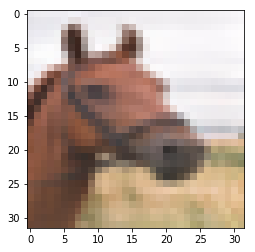

In [6]:
influence_target = 99

# display
print(_classes[int(feeder.test_label[influence_target])])
plt.imshow(feeder.test_origin_data[influence_target])

test_indices = [influence_target]
testset_batch_size = 100

train_batch_size = 100
train_iterations = 500

# train_batch_size = 100
# train_iterations = 50

approx_params = {
    'scale': 200,
    'num_repeats': 5,
    'recursion_depth': 100,
    'recursion_batch_size': 100
}

### Run upweight influence function

In [7]:
scores = inspector.upweighting_influence_batch(
    sess,
    test_indices,
    testset_batch_size,
    approx_params,
    train_batch_size,
    train_iterations)


2017-12-05 11:14:56,562 darkon INFO: Loaded inverse HVP from ./influence-workspace/ihvp.b98ee10f2b34001baacd7f7c9d991dc7269f666a.npz
2017-12-05 11:14:59,560 darkon INFO: iter: 0/500
2017-12-05 11:17:41,991 darkon INFO: iter: 100/500
2017-12-05 11:20:24,469 darkon INFO: iter: 200/500
2017-12-05 11:23:06,989 darkon INFO: iter: 300/500
2017-12-05 11:25:49,490 darkon INFO: iter: 400/500
2017-12-05 11:28:30,413 darkon INFO: Multiplying by 50000 train examples


### Check helpful/unhelpful indices and scores

In [9]:
sorted_indices = np.argsort(scores)
harmful = sorted_indices[:10]
helpful = sorted_indices[-10:][::-1]

print('\nHarmful:')
for idx in harmful:
    print('[{}] {}'.format(idx, scores[idx]))
    
print('\nHelpful:')
for idx in helpful:
    print('[{}] {}'.format(idx, scores[idx]))




Harmful:
[18478] -9.36771160569e-05
[42222] -8.46885512388e-05
[2246] -8.23998404172e-05
[39682] -8.15817918578e-05
[7229] -8.08642833876e-05
[7160] -8.05636397091e-05
[28758] -7.9250986622e-05
[45043] -7.84012108295e-05
[29760] -7.79298778885e-05
[11034] -7.69196971133e-05

Helpful:
[14989] 0.000366907128463
[5447] 0.000359578592733
[10358] 0.000346645738134
[42546] 0.00034359990294
[46517] 0.000342480261472
[6189] 0.000340015075372
[27038] 0.000336939708588
[11595] 0.000335732673077
[26193] 0.0003327236202
[7682] 0.000331258270667


### Display helpful train data

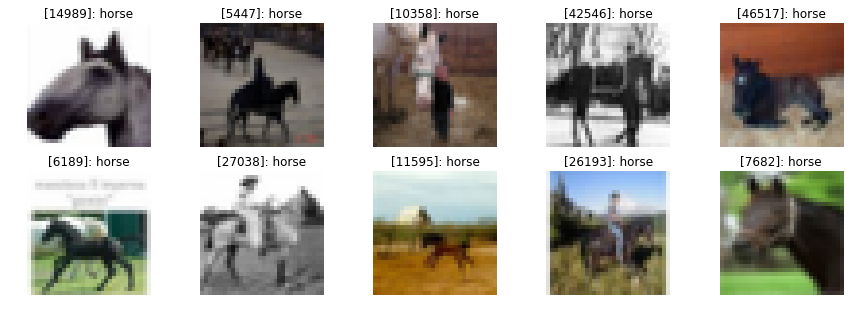

In [10]:
fig, axes1 = plt.subplots(2, 5, figsize=(15, 5))
target_idx = 0
for j in range(2):
    for k in range(5):
        idx = helpful[target_idx]
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(feeder.train_origin_data[idx])
        label_str = _classes[int(feeder.train_label[idx])]
        axes1[j][k].set_title('[{}]: {}'.format(idx, label_str))

        target_idx += 1

### Display harmful train data

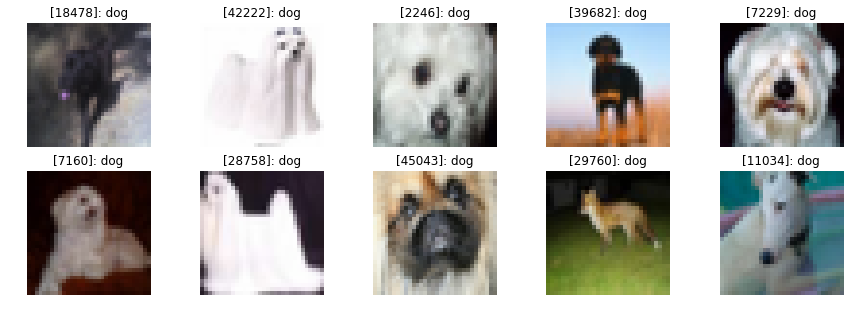

In [11]:
fig, axes1 = plt.subplots(2, 5, figsize=(15, 5))
target_idx = 0
for j in range(2):
    for k in range(5):
        idx = harmful[target_idx]
        axes1[j][k].set_axis_off()
        axes1[j][k].imshow(feeder.train_origin_data[idx])
        label_str = _classes[int(feeder.train_label[idx])]
        axes1[j][k].set_title('[{}]: {}'.format(idx, label_str))

        target_idx += 1

***
>***[Copyright 2017 Neosapience, Inc.](http://www.neosapience.com)***
>
>Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

>    http://www.apache.org/licenses/LICENSE-2.0

>Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

***